4326


c:\Users\Domi\anaconda3\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Domi\anaconda3\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: 'ToPILImage' object has no attribute 'permute'

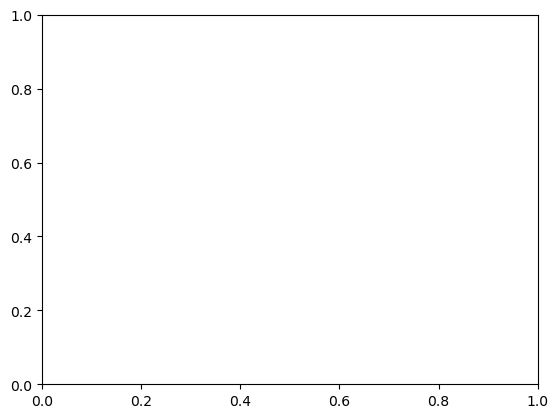

In [1]:
import os
import json
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from torchvision.models.detection import ssd
from PIL import Image

from tqdm import tqdm

from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.models.vgg import VGG16_Weights


root_dir = r"C:\Users\Domi\Documents\GitHub\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask"

NORMALIZATION = True
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 8
ALLOWED_LABELS = [3, 4, 5, 6]
RESIZE = (300, 300)
ROUND_RESIZED_BBOXES = False
TEST_SIZE = 0.2



class DatasetLoader:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, "images")
        self.annotations_dir = os.path.join(root_dir, "annotations")
    
    
    def load_dataset(self):
        dataset = []
        supported_image_extensions = (".jpg", ".jpeg", ".png")
        supported_annotation_extensions = (".jpg.json", ".jpeg.json", ".png.json")  # Beispielerweiterungen, anpassen Sie dies entsprechend

        for filename in os.listdir(self.images_dir):
            if filename.lower().endswith(supported_image_extensions):
                image_path = os.path.join(self.images_dir, filename)

                # Annotationen
                annotation_filename = os.path.splitext(filename)[0]
                for extension in supported_annotation_extensions:
                    annotation_file = annotation_filename + extension
                    annotation_path = os.path.join(self.annotations_dir, annotation_file)
                    if os.path.exists(annotation_path):
                        break

                # Bild und Annotationen einlesen
                image, annotations = self._read_data(image_path, annotation_path)
                dataset.append((image, annotations))

        return dataset



    def _read_data(self, image_path, annotation_path):
        image = Image.open(image_path)
        
        with open(annotation_path, 'r') as f:
            annotations = json.load(f)
        
        image_annotations = {
            "filename": annotations["FileName"],
            "annotations": []
        }
        
        for annotation in annotations["Annotations"]:
            bbox = annotation["BoundingBox"]
            xmin, ymin, xmax, ymax = bbox
            label = annotation["classname"]
            
            formatted_annotation = {
                "bbox": [xmin, ymin, xmax, ymax],
                "label": label
            }
            
            image_annotations["annotations"].append(formatted_annotation)
        
        return image, image_annotations
    



dataset_loader = DatasetLoader(root_dir)
dataset = dataset_loader.load_dataset()
image, annotations = dataset[0]
print(len(dataset))





class MyCustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset[index]
        image = self.transform(data[0])  # Bild in Tensor umwandeln
        annotations = data[1]  # Annotationen beibehalten

        return image, annotations
    


def collate_fn(batch):
    images = []
    annotations = []
    annotation_list = []  # Separate Liste für die Annotationen

    # Definiere die Zielgröße für das Rescaling
    target_size = (300, 300)

    # Erstelle die Rescaling-Transformation
    rescale_transform = transforms.Resize(target_size, interpolation=Image.Resampling.BILINEAR)

    for image, annotation in batch:
        # Wandele den Tensor in eine PIL-Image-Instanz um
        image_size = image.size()
        image = transforms.ToPILImage()(image)

        # Wende die Rescaling-Transformation auf das Bild an
        image = rescale_transform(image)

        # Konvertiere das Bild in ein Tensor und füge es zur Liste hinzu
        image = transforms.ToTensor()(image)
        images.append(image)

        # Passe die Bounding-Boxen an die neue Größe des Bildes an
        width_ratio = target_size[0] / image_size[2]
        height_ratio = target_size[1] / image_size[1]
        for bbox_dict in annotation['annotations']:
            bbox = bbox_dict['bbox']
            x_min, y_min, x_max, y_max = bbox
            x_min *= width_ratio
            y_min *= height_ratio
            x_max *= width_ratio
            y_max *= height_ratio
            bbox_dict['bbox'] = [x_min, y_min, x_max, y_max]

        # Füge die Annotations zur Annotations-Liste hinzu
        annotations.append(annotation)

    # Passe die Größen der Bilder an, um stapelbar zu sein
    images = torch.stack(images)

    # Normalize die Pixelwerte der Bilder
    images = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(images)

    return images, annotations



from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.models.vgg import VGG16_Weights

batch_size = 64

# Modell initialisieren
#, weights_backbone = VGG16_Weights.DEFAULT
#model = ssd.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
model = ssd.ssd300_vgg16(pretrained=True)

# Daten in Trainings- und Testdaten aufteilen
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

#len(train_dataset)
# Trainingsdaten vorbereiten und DataLoader erstellen
train_dataset = MyCustomDataset(train_data)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
#train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

# Testdaten vorbereiten und DataLoader erstellen
test_dataset = MyCustomDataset(test_data)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Optimizer und Loss-Funktion definieren
optimizer = torch.optim.SGD(model.parameters(), lr=0.00005, momentum=0.9, weight_decay=0.0005, nesterov=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)


mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
class_mapping = {
    "hijab_niqab": 0,
    "mask_colorful": 1,
    "mask_surgical": 2,
    "face_no_mask": 3,
    "face_with_mask_incorrect": 4,
    "face_with_mask": 5,
    "face_other_covering": 6,
    "scarf_bandana": 7,
    "balaclava_ski_mask": 8,
    "face_shield": 9,
    "other": 10,
    "gas_mask": 11,
    "turban": 12,
    "helmet": 13,
    "sunglasses": 14,
    "eyeglasses": 15,
    "hair_net": 16,
    "hat": 17,
    "goggles": 18,
    "hood": 19
}





def visualize_sample(dataloader, x):
    # Rufen Sie das x-te Element aus dem Dataloader ab
    x -=1 
    images, annotations = next(iter(dataloader))
    image = transforms.ToPILImage(images[x])
    boxes = annotations[x]['annotations']

    # Erstellen Sie eine neue Figur und Achse
    fig, ax = plt.subplots(1)

    # Zeigen Sie das Bild in der Achse an
    ax.imshow(image)

    # Iterieren Sie über die Bounding Boxes und zeichnen Sie sie als Rechtecke in der Achse
    for box in boxes:
        x_min, y_min, x_max, y_max = box['bbox']
        width = x_max - x_min
        height = y_max - y_min
        #print(width, height)
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


    # Zeigen Sie die visualisierten Bounding Boxes an
    plt.show()

visualize_sample(train_dataloader, 1)




def draw_image_with_boxes(image, target):
    #image = image.cpu().permute(1, 2, 0).numpy()
    # Unnormalize the image
    image_unnormalized = transforms.Normalize(mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std])(image)
    image_pil = transforms.ToPILImage()(image_unnormalized)

    # Kopiere die Bounding-Box-Koordinaten auf die CPU und konvertiere sie in numpy-Arrays
    boxes = target["boxes"]
    labels = target["labels"]
    boxes = boxes.cpu().numpy()
    labels = labels.cpu().numpy()
        
    # Erstelle eine neue Figur und Achse
    fig, ax = plt.subplots(1)
    
    # Zeige das Bild in der Achse
    ax.imshow(image_pil)
    print(target)

    allowed_labels = [3, 4, 5, 6]
    # Iteriere über die Bounding-Boxen und zeichne sie als Rechtecke in der Achse
    for box, label in zip(boxes, labels):
        for label in allowed_labels:
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f"Label: {class_mapping[label]}", color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Zeige die Achse
    plt.show()


def check_labels(target):
    labels = target['labels']
    boxes = target['boxes']

    num_boxes = boxes.size(0)
    num_labels = labels.size(0)

    if num_labels != num_boxes:
        print("Error: Labels are not in the expected format.")


def visualize_prediction(images, model, confidence_threshold, counter = 10):
    # Set the model to evaluation mode
    model.eval()
    # Preprocess the images
    
    # Perform inference
    with torch.no_grad():
        predictions = model(images)
        #good = torch.argwhere(scores > confidence_threshold)

    for image, prediction in zip(images, predictions):
        # Convert the image tensor to a PIL Image
        #image_pil = transforms.ToPILImage()(image)

        # Unnormalize the image
        image_unnormalized = transforms.Normalize(mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std])(image)
        image_pil = transforms.ToPILImage()(image_unnormalized)


        # Get the predicted bounding boxes, labels, and scores
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        # Visualize the image and predicted bounding boxes
        fig, ax = plt.subplots(1)
        ax.imshow(image_pil)
        allowed_labels = [3, 4, 5, 6]

        for box, label, score in zip(boxes, labels, scores):
            if label in allowed_labels and score > confidence_threshold and counter%10 == 0:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                class_name = list(class_mapping.keys())[list(class_mapping.values()).index(label)]
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{class_name}", color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
                counter=0
        plt.show()
    model.train()




from coco_eval import CocoEvaluator


def calculate_mAP(model, dataloader, device):
    # Set the model to evaluation mode
    model.eval()

    coco_evaluator = CocoEvaluator(dataloader.dataset.coco, iou_types="bbox")

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images, targets)
            coco_evaluator.update(targets, outputs)

    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

    mAP = coco_evaluator.stats[0]

    return mAP

# # Trainingsschleife
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()



for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    total_iterations = len(train_dataloader)
    total_loss = 0.0
    counter = 0
    
    for images, annotations in pbar:
        images = images.to(device)
        
        # Annotationsdaten aufbereiten
        targets = []

        for annotation in annotations:
            boxes = annotation["annotations"]
            labels = [box["label"] for box in boxes]
            bboxes = [box["bbox"] for box in boxes]
            #print(boxes[0])

            # Wandele Labels in numerische Werte um
            labels = [class_mapping[label] for label in labels]

            target = {
                "boxes": torch.tensor(bboxes, dtype=torch.float32).to(device),
                "labels": torch.tensor(labels, dtype=torch.int64).to(device)
            }
            check_labels(target)
            targets.append(target)

        optimizer.zero_grad()

        
        # print(targets[0]['boxes'].size())
        # print(images[0].shape)
        # print(images[0])
        # print(targets[0])
        # break


        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        average_loss = total_loss / (pbar.n + 1)
        
        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Average-Loss: {average_loss:.4f}, Loss: {losses.item():.4f}")

        #draw_image_with_boxes(images[0], targets[0])
        if (counter + 1) % (total_iterations // 20) == 0:
            visualize_prediction([images[0]], model, confidence_threshold=0.3)
        #visualize_prediction(images, model, confidence_threshold=0.3, counter=counter)
        counter += 1


    
    pbar.close()